In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
import math

In [2]:
iris = load_iris()

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
target = pd.Series(iris.target, dtype="category")
df['species'] = target

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
df.groupby('species').size()
# 각 종의 데이터는 모두 50개씩 존재한다.

species
0    50
1    50
2    50
dtype: int64

In [7]:
#iris.data -> features, iris.target -> labels
X = df.drop(['species'],axis=1)
y = pd.DataFrame(df['species'],columns=['species'])

In [8]:
X.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


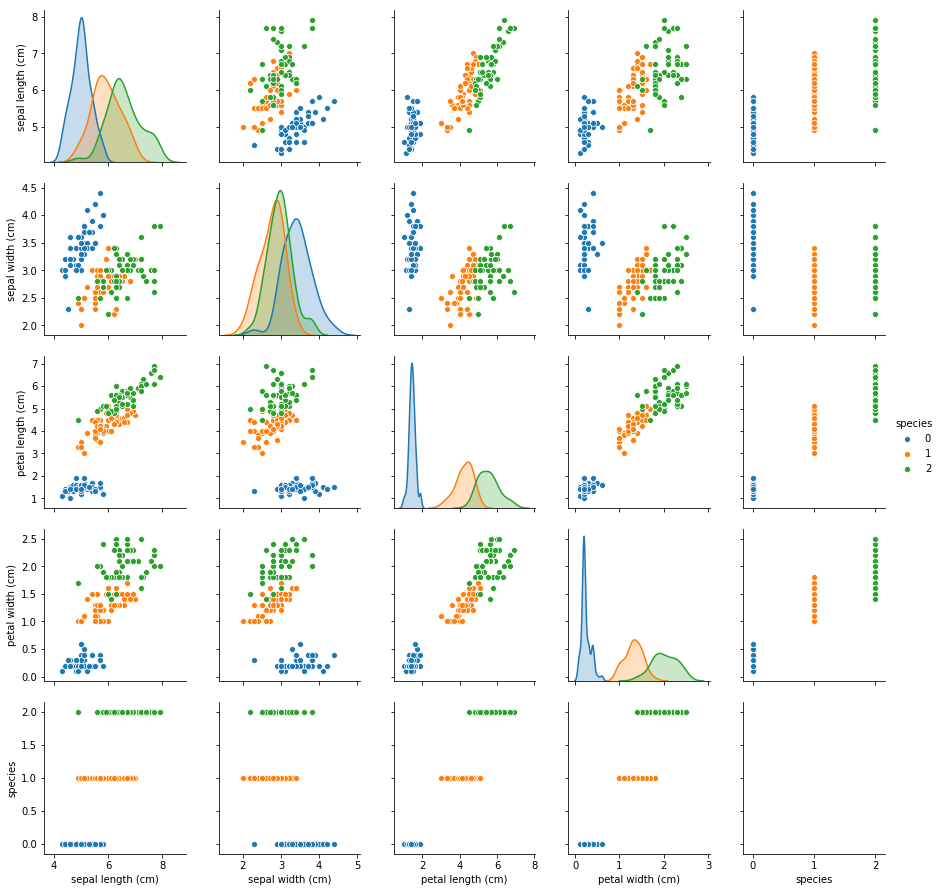

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.pairplot(df, hue="species")
plt.show()

# petal length 만으로 0과 1종을 완전히 구분할 수 있다
# petal length와 petal width 두가지로 나누면 1과 2종도 구분해 낼 수 있을 것으로 보인다

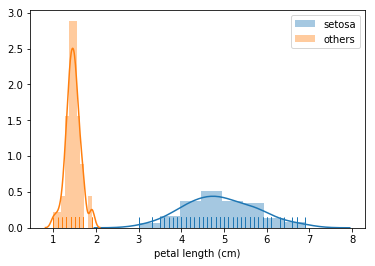

In [11]:
sns.distplot(df[df.species != 0]["petal length (cm)"], hist=True, rug=True, label="setosa")
sns.distplot(df[df.species == 0]["petal length (cm)"], hist=True, rug=True, label="others")
plt.legend()
plt.show()
# petal length 또는 petal width 만으로 setosa를 완전히 구분할 수 있다

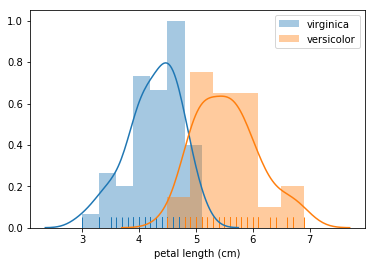

In [12]:
sns.distplot(df[df.species == 1]["petal length (cm)"], hist=True, rug=True, label="virginica")
sns.distplot(df[df.species == 2]["petal length (cm)"], hist=True, rug=True, label="versicolor")
plt.legend()
plt.show()
# 하지만 petal length로 virginica와 versicolor를 완전히 구분해내기는 힘들다

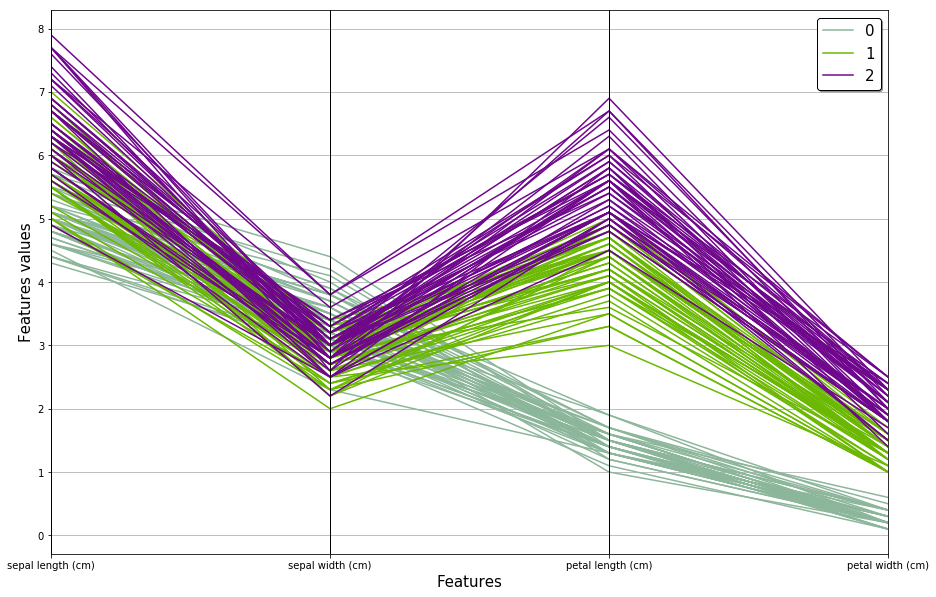

In [13]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(15,10))
parallel_coordinates(df, "species")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features values', fontsize=15)
plt.legend(loc=1, prop={'size': 15}, frameon=True, shadow=True, facecolor="white", edgecolor="black")
plt.show()

# 각 feature들로 얼마나 붓꽃 종류를 구분할 수 있는지 한눈에 알 수 있다.
# 앞에서 언급했듯이 petal length와 petal width로 0과 1를 구분해낼 수 있다

In [14]:
#iris.data -> features, iris.target -> labels
X = iris.data
y = iris.target

In [15]:
# split into test and train dataset, and use random_state=48
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=48)

In [16]:
trainSet = np.column_stack((X_train, y_train))
testSet = np.column_stack((X_test, y_test))

In [17]:
trainSet[:,-1]

array([2., 2., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 2., 0., 2., 1., 2.,
       1., 2., 1., 2., 2., 0., 1., 1., 2., 2., 1., 1., 2., 2., 1., 1., 1.,
       2., 1., 1., 2., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 2., 2., 0.,
       0., 2., 0., 1., 2., 1., 0., 0., 2., 2., 1., 0., 2., 0., 1., 0., 2.,
       1., 0., 2., 0., 2., 0., 0., 0., 2., 2., 0., 2., 0., 0., 2., 1., 0.,
       2., 2., 0., 0., 2., 0., 1., 0., 2., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0.])

### KNN Classifier Implementation

In [18]:
def getDistance(p, instance1, instance2):
    # p=1 : return Manhattan Distance
    # p=2 : return Eucludean Distance
    distance = np.sum(pow(abs(instance1 - instance2), p))
    return distance ** (1/p)

In [19]:
def getWeight(k, distance):
    weight = np.zeros(k)
    sum = 0
    for i in range(k):
        weight[i] += 1 / distance[i]
        sum += weight[i]
    return weight / sum

In [20]:
import operator

def getNeighbors(p, trainSet, testInstance, k):
    # p=1 : return Manhattan Distance
    # p=2 : return Eucludean Distance
    distances = []
    for i in range(len(trainSet)):
        dist = getDistance(p, trainSet[i][:-1], testInstance[:-1]) # 각 trainSet마다 testInstance와의 거리 계산
        distances.append([trainSet[i], dist])
    distances.sort(key=operator.itemgetter(1)) # 거리를 기준으로 정렬
    
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i]) # 데이터를 k번째까지 neighbors에 저장
    return neighbors

In [21]:
def getResponse(neighbors, weightKnn):
    classVotes = {}
    neighbors = np.array(neighbors)
    weight = getWeight(k, neighbors[:, -1])
    for i in range(len(neighbors)):
        response = neighbors[i][0][-1]
        if response in classVotes:
            if weightKnn == True:
                classVotes[response] += 1 * weight[i]
            else:
                classVotes[response] += 1
        else:
            classVotes[response] = 1
    vote = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return vote[0][0] # 가장 투표를 많이 받은 클래스 리턴

In [22]:
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    accuracy = (correct/len(testSet)) * 100.0
    return accuracy

In [23]:
k = 3
p = 2 # Euclidean distance

In [24]:
predictions=[]

# KNN
for i in range(len(testSet)):
    neighbors = getNeighbors(p, trainSet, testSet[i], k)
    result = getResponse(neighbors, False)
    predictions.append(result)
    print(str(i) + ' > predicted : ' + str(result) + ', actual : ' + str(testSet[i][-1]))

0 > predicted : 1.0, actual : 1.0
1 > predicted : 1.0, actual : 1.0
2 > predicted : 2.0, actual : 2.0
3 > predicted : 0.0, actual : 0.0
4 > predicted : 1.0, actual : 1.0
5 > predicted : 2.0, actual : 2.0
6 > predicted : 0.0, actual : 0.0
7 > predicted : 1.0, actual : 2.0
8 > predicted : 0.0, actual : 0.0
9 > predicted : 1.0, actual : 1.0
10 > predicted : 2.0, actual : 2.0
11 > predicted : 0.0, actual : 0.0
12 > predicted : 0.0, actual : 0.0
13 > predicted : 2.0, actual : 2.0
14 > predicted : 1.0, actual : 1.0
15 > predicted : 1.0, actual : 1.0
16 > predicted : 0.0, actual : 0.0
17 > predicted : 1.0, actual : 1.0
18 > predicted : 2.0, actual : 1.0
19 > predicted : 2.0, actual : 2.0
20 > predicted : 0.0, actual : 0.0
21 > predicted : 2.0, actual : 2.0
22 > predicted : 1.0, actual : 1.0
23 > predicted : 1.0, actual : 1.0
24 > predicted : 2.0, actual : 2.0
25 > predicted : 0.0, actual : 0.0
26 > predicted : 0.0, actual : 0.0
27 > predicted : 2.0, actual : 2.0
28 > predicted : 2.0, actual :

In [25]:
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: ' + str(accuracy) + '%')

Accuracy: 95.55555555555556%


In [26]:
predictions=[]

# Weighted KNN
for i in range(len(testSet)):
    neighbors = getNeighbors(p, trainSet, testSet[i], k)
    result = getResponse(neighbors, True)
    predictions.append(result)
    print(str(i) + ' > predicted : ' + str(result) + ', actual : ' + str(testSet[i][-1]))

0 > predicted : 1.0, actual : 1.0
1 > predicted : 1.0, actual : 1.0
2 > predicted : 2.0, actual : 2.0
3 > predicted : 0.0, actual : 0.0
4 > predicted : 1.0, actual : 1.0
5 > predicted : 2.0, actual : 2.0
6 > predicted : 0.0, actual : 0.0
7 > predicted : 1.0, actual : 2.0
8 > predicted : 0.0, actual : 0.0
9 > predicted : 1.0, actual : 1.0
10 > predicted : 2.0, actual : 2.0
11 > predicted : 0.0, actual : 0.0
12 > predicted : 0.0, actual : 0.0
13 > predicted : 2.0, actual : 2.0
14 > predicted : 1.0, actual : 1.0
15 > predicted : 1.0, actual : 1.0
16 > predicted : 0.0, actual : 0.0
17 > predicted : 1.0, actual : 1.0
18 > predicted : 2.0, actual : 1.0
19 > predicted : 2.0, actual : 2.0
20 > predicted : 0.0, actual : 0.0
21 > predicted : 2.0, actual : 2.0
22 > predicted : 1.0, actual : 1.0
23 > predicted : 1.0, actual : 1.0
24 > predicted : 2.0, actual : 2.0
25 > predicted : 0.0, actual : 0.0
26 > predicted : 0.0, actual : 0.0
27 > predicted : 2.0, actual : 2.0
28 > predicted : 2.0, actual :

In [27]:
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: ' + str(accuracy) + '%')

Accuracy: 95.55555555555556%


In [37]:
# 적당한 K 찾기

k_range = range(1, 31)
k_scores = []

In [38]:
for k in k_range:
    predictions=[]
    for i in range(len(testSet)):
        neighbors = getNeighbors(p, trainSet, testSet[i], k)
        result = getResponse(neighbors, False)
        predictions.append(result)
    k_scores.append(getAccuracy(testSet, predictions))

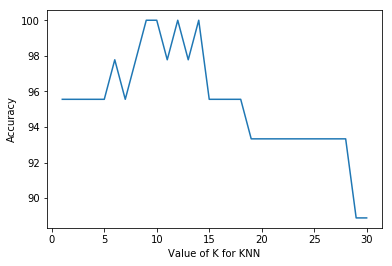

In [39]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy')
plt.show()

In [40]:
k_scores

[95.55555555555556,
 95.55555555555556,
 95.55555555555556,
 95.55555555555556,
 95.55555555555556,
 97.77777777777777,
 95.55555555555556,
 97.77777777777777,
 100.0,
 100.0,
 97.77777777777777,
 100.0,
 97.77777777777777,
 100.0,
 95.55555555555556,
 95.55555555555556,
 95.55555555555556,
 95.55555555555556,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 93.33333333333333,
 88.88888888888889,
 88.88888888888889]

In [41]:
k = 9
predictions = []
for i in range(len(testSet)):
    neighbors = getNeighbors(p, trainSet, testSet[i], k)
    result = getResponse(neighbors, False)
    predictions.append(result)
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: ' + str(accuracy) + '%')

Accuracy: 100.0%
